This notebook visualizes CIFAR10 users using various methods of generating simulation users.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import joblib

from ramsay.data.sampling import get_data_sampler
from polya_mixture.datasets.cifar10_dataset import load_and_preprocess
from polya_mixture.datasets.sampler import DirichletDataSampler

In [2]:
# Functions to generate users

def generate_mixture_users(num_users, alphas, phi, num_samples_dists, all_labels):
    users = []
    ks = []
    for _ in range(num_users):
        k = np.random.choice(range(len(alphas)), p=phi)
        d = num_samples_dists[k]
        n = np.random.choice(range(len(d)), p=d)

        sampler = DirichletDataSampler(alphas[k], all_labels)
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

def generate_single_dirichlet_users(num_users, alpha, user_len_sampler, all_labels):
    sampler = DirichletDataSampler(alpha, all_labels)
    users = []
    for _ in range(num_users):
        n = user_len_sampler()
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

def generate_uniform_users(num_users, user_len_sampler, all_labels):
    sampler = get_data_sampler('random', len(all_labels))
    users = []
    for _ in range(num_users):
        n = user_len_sampler()
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

In [3]:
# Load Cifar10 and get all labels
data_dir = 'data/cifar10'
_, all_labels, _, _ = load_and_preprocess(os.path.join(data_dir, 'cifar10_train.p'))

dict_keys(['alphas', 'phi'])
alpha_mixture [[0.2790543  0.19542773 1.7441087  0.9729872  0.18570527 0.09938517
  0.09327706 0.10400821 3.144703   1.0748252 ]
 [0.26441148 0.17979808 0.11472267 0.99709547 1.2816628  1.3844566
  0.98972297 0.4767252  1.1671178  0.0879145 ]]
phi_mixture [0.9021526  0.09784738]
num_samples_distribution_mixture (2, 500)
(2,) (2, 10) (2, 500)


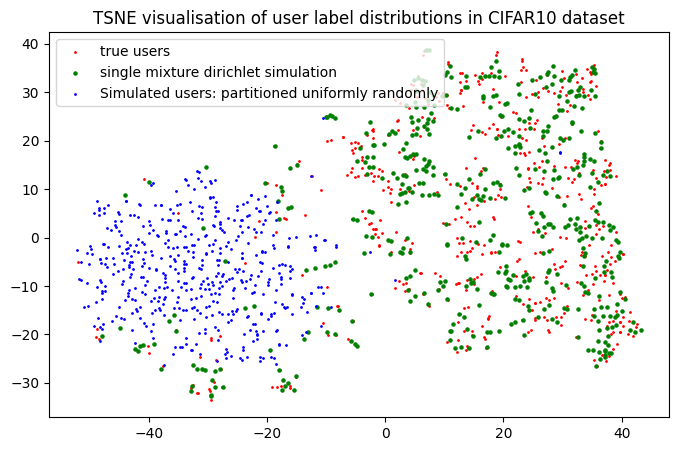

In [12]:
# Load single dirichlet saved params
mixture = True

if not mixture:
    # load learned parameters
    params = joblib.load(os.path.join('mle_params', 'cifar10_1_mixture', 'polya-mixture.joblib'))
    print(params.keys())
    alpha_one_component =  np.array(params['alphas'][0])
    
    num_samples_distribution_one_component = joblib.load(os.path.join('num_samples_distribution', 'cifar10_1_mixture.joblib'))
    num_samples_distribution_one_component = num_samples_distribution_one_component.numpy().reshape(-1,)
    
    len_sampler = lambda: np.random.choice(range(len(num_samples_distribution_one_component)), p=num_samples_distribution_one_component)

    # true distribution
    true_alpha = [0.3, 0.2, 0.1, 1, 1.2, 1.3, 0.8, 0.5, 1.2, 0.1]
    true_len_sampler = lambda: 20

    # create distributions
    num_users = 500
    true_users = generate_single_dirichlet_users(num_users, true_alpha, true_len_sampler, all_labels)
    simulated_single_dirichlet_users = generate_single_dirichlet_users(num_users, alpha_one_component, len_sampler, all_labels)
    simulated_uniform_users = generate_uniform_users(num_users, len_sampler, all_labels)

    # Run TSNE on the label counts of all users
    tsne2 = TSNE(n_components=2)
    X = np.vstack([true_users, simulated_single_dirichlet_users, simulated_uniform_users])
    X = X / X.sum(axis=1, keepdims=True) # This will normalize the counts to proportions to ignore num sample per user effects
    X_2dim = tsne2.fit_transform(X)

    N = num_users
    plt.figure(figsize=(8, 5))
    plt.title('TSNE visualisation of user label distributions in CIFAR10 dataset')
    plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='true users')
    plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=5, color='green', label='single dirichlet simulation')
    plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
    plt.legend(fontsize=10)


else:
    # Load two component mixture dirichlet saved params
    params = joblib.load(os.path.join('mle_params', 'cifar10_2_mixture', 'polya-mixture.joblib'))
    print(params.keys())
    alpha_mixture =  np.array(params['alphas'])
    print('alpha_mixture', alpha_mixture)
    phi_mixture = np.array(params['phi'])
    phi_mixture /= sum(phi_mixture)
    print('phi_mixture', phi_mixture)
    
    num_samples_distribution_mixture = joblib.load(os.path.join('num_samples_distribution', 'cifar10_2_mixture.joblib'))
    num_samples_distribution_mixture = num_samples_distribution_mixture.numpy()
    print('num_samples_distribution_mixture', num_samples_distribution_mixture.shape)
    print(phi_mixture.shape, alpha_mixture.shape, num_samples_distribution_mixture.shape)

    # true distribution
    #true_alpha = [[1.8]*10, [0.2]*10]
    #true_phi = [0.3, 0.7]
    true_alpha = [[0.3, 0.2, 0.1, 1, 1.2, 1.3, 0.8, 0.5, 1.2, 0.1], [0.3, 0.2, 1.8, 1, 0.2, 0.1, 0.1, 0.1, 3.2, 1.1]]
    true_phi = [0.1, 0.9]

    # generate users
    num_users = 500
    # TODO change num_samples_distribution_mixture so it's not just tied to learned parameters, but is the actual true distribution
    true_users = generate_mixture_users(num_users, true_alpha, true_phi, num_samples_distribution_mixture, all_labels)
    simulated_dirichlet_mixture_users = generate_mixture_users(num_users, alpha_mixture, phi_mixture, num_samples_distribution_mixture, all_labels)
    len_sampler = lambda: 20
    simulated_uniform_users = generate_uniform_users(num_users, len_sampler, all_labels)

    # Run TSNE on the label counts of all users
    tsne2 = TSNE(n_components=2)
    X = np.vstack([true_users, simulated_dirichlet_mixture_users, simulated_uniform_users]) 
    X = X / X.sum(axis=1, keepdims=True) # This will normalize the counts to proportions to ignore num sample per user effects
    X_2dim = tsne2.fit_transform(X)
    
    # plot
    N = num_users
    plt.figure(figsize=(8, 5))
    plt.title('TSNE visualisation of user label distributions in CIFAR10 dataset')
    plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='true users')
    plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=5, color='green', label='single mixture dirichlet simulation')
    plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
    plt.legend(fontsize=10)